In [2]:
import numpy as np
from scipy.interpolate import interp1d
import pylab as pl
from scipy.integrate import quad
%matplotlib inline

In [3]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in' 

In [9]:
# Setting velocity and spatial grid points
N_positions = 8
ghost_zones = 3
N_velocity  = 201

In [10]:
# Boundaries of domain
left_boundary  = 0
right_boundary = 1.0
length         = right_boundary - left_boundary

In [11]:
# Setting mass of the particle, boltzmann-constant
mass_particle      = 1.0
boltzmann_constant = 1.0

In [12]:
# Scattering time scale
tau   = 1.0
# Magnitude of maximum velocity
v_max = 10

In [13]:
# Time Parameters for the simulation:
dt         = 0.01 # Size of the time-step
final_time = 1.0
time       = np.arange(dt, final_time, dt)

In [14]:
# Setting up the temperature parameters for the simulations:
T_initial = 1.0

In [15]:
# Setting up of spatial and velocity grids:
x  = np.linspace(left_boundary, right_boundary, N_positions)
dx = x[1] - x[0]

In [16]:
# Obtaining the coordinates for the ghost-zones:
x_ghost_left  = np.linspace(-(ghost_zones)*dx + left_boundary, left_boundary - dx, ghost_zones)
x_ghost_right = np.linspace(right_boundary + dx, right_boundary + ghost_zones*dx , ghost_zones)

In [17]:
# Combining them to obtain the entire spatial grid
x  = np.concatenate([x_ghost_left, x, x_ghost_right])

In [18]:
# Obtaining the velocity grid
v  = np.linspace(-v_max, v_max, N_velocity)

In [19]:
# Conversion to allow for easy vectorization
x = x * np.ones([N_velocity , N_positions + 2*ghost_zones])
v = v * np.ones([N_positions + 2*ghost_zones, N_velocity])
v = np.transpose(v)

In [20]:
def calculate_density(f, v):
    deltav           = v[1, 0]-v[0, 0]
    value_of_density = np.sum(f, axis = 0)*deltav
    return(value_of_density)

In [21]:
def calculate_temperature(f, v):
    deltav               = v[1, 0]-v[0, 0]
    value_of_temperature = np.sum(f*v**2, axis = 0)*deltav
    return(value_of_temperature)

In [22]:
def f_MB(x, v, f):
    n = calculate_density(f, v) * np.ones([N_velocity, N_positions + 2*ghost_zones])
    T = calculate_temperature(f, v) * np.ones([N_velocity, N_positions + 2*ghost_zones])
    f_MB = n*np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T))*\
             np.exp(-mass_particle*v**2/(2*boltzmann_constant*T))
    return(f_MB)

In [23]:
def f_interp(dt, x, v, f):
    x_new     = x - v*(dt)
    f_interp  = np.zeros([N_velocity, N_positions + 2*ghost_zones])

    for i in range(N_velocity):
        left_indices   = np.where(x_new[i, ghost_zones:-ghost_zones]<=left_boundary)[0]
        right_indices  = np.where(x_new[i, ghost_zones:-ghost_zones]>=right_boundary)[0]
        wall_indices   = np.concatenate([left_indices, right_indices])
        all_indices    = np.arange(N_positions)
        indices_domain = np.delete(all_indices, wall_indices)
        
        interpolated_function                     = interp1d(x[i, :], f[i, :], 'cubic')
        f_interp[i, ghost_zones + indices_domain] = interpolated_function(x_new[i, ghost_zones + indices_domain])
    
        # Implementation of periodic B.C's
        for j in left_indices:
            while(x_new[i, j + ghost_zones]<left_boundary):
                x_new[i, j + ghost_zones] = x_new[i, j + ghost_zones] + length

        for j in right_indices:
            while(x_new[i, j + ghost_zones]>right_boundary):
                x_new[i, j + ghost_zones] = x_new[i, j + ghost_zones] - length

        for j in left_indices:
            f_interp[i, j + ghost_zones] = interpolated_function(x_new[i, j + ghost_zones])

        for j in right_indices:
            f_interp[i, j + ghost_zones] = interpolated_function(x_new[i, j + ghost_zones])

    return f_interp

In [24]:
# Intializing the values for rho with a sinusoidal perturbation
X                                                          = np.zeros(N_positions + 2*ghost_zones)
X[ghost_zones:-ghost_zones]                                = np.linspace(0, 2*np.pi, N_positions)
Y                                                          = 0.1*np.sin(X) + 1
Y[:ghost_zones]                                            = Y[(N_positions - 1):(N_positions + ghost_zones - 1)]
Y[N_positions + ghost_zones:N_positions + 2 * ghost_zones] = Y[(ghost_zones + 1):(1 + 2*ghost_zones)]

rho_init = Y
rho_init = rho_init * np.ones([N_velocity , N_positions + 2*ghost_zones])

In [25]:
# Initializing the initial distribution function:
f_initial = rho_init * np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_initial)) * \
                       np.exp(-mass_particle*v**2/(2*boltzmann_constant*T_initial))

In [26]:
# Initializing the value of f_current for running the simulation:
f_current = f_initial

In [27]:
# Declaring a variable which will store the maximum values of density:
rho_max = np.zeros(time.size)

In [28]:
for time_index, t0 in enumerate(time):

    print("Computing For Time Index = ", time_index)
    # print("Physical Time            = ", t0)

    # We shall split the Boltzmann-Equation and solve it:
    # In this step we are solving the collisionless equation
    fstar = f_interp(dt, x, v, f_current)
    fstar[:, :ghost_zones] = fstar[:, (N_positions - 1):(N_positions + ghost_zones - 1)]
    fstar[:, N_positions + ghost_zones:N_positions + 2 * ghost_zones] = fstar[:, (ghost_zones + 1):(1 + 2*ghost_zones)]

    # We turn off the term v(df/dx) for the following two steps
    #f0             = f_MB(x, v, fstar)
    #f_intermediate = fstar - (dt/2)*(fstar          - f0)/tau
    
    #f_intermediate[:, :ghost_zones] = f_intermediate[:, (N_positions - 1):(N_positions + ghost_zones - 1)]
    #f_intermediate[:, N_positions + ghost_zones:N_positions + 2 * ghost_zones] = f_intermediate[:, (ghost_zones + 1):(1 + 2*ghost_zones)]
    
    #f_new          = fstar - (dt)  *(f_intermediate - f0)/tau
    
    # Implementation of periodic B.C's:
    #f_new[:, :ghost_zones] = f_new[:, (N_positions - 1):(N_positions + ghost_zones - 1)]
    #f_new[:, N_positions + ghost_zones:N_positions + 2 * ghost_zones] = f_new[:, (ghost_zones + 1):(1 + 2*ghost_zones)]
    f_current = fstar
    rho_max[time_index] = np.max(abs(calculate_density(f_current, v)))

Computing For Time Index =  0
Computing For Time Index =  1
Computing For Time Index =  2
Computing For Time Index =  3
Computing For Time Index =  4
Computing For Time Index =  5
Computing For Time Index =  6
Computing For Time Index =  7
Computing For Time Index =  8
Computing For Time Index =  9
Computing For Time Index =  10
Computing For Time Index =  11
Computing For Time Index =  12
Computing For Time Index =  13
Computing For Time Index =  14
Computing For Time Index =  15
Computing For Time Index =  16
Computing For Time Index =  17
Computing For Time Index =  18


In [29]:
N  = 512
Nt = 100
dx = 1./N
i  = np.arange(0, N, 1)
x  = (i + 0.5)*dx
tFinal  = 1.
t  = np.linspace(0, tFinal, Nt)

amplitude   = 0.1
k           = 2*np.pi
theta0      = T_initial
rho0        = 1.0

def rhoInit(x):
    return rho0 + amplitude*np.sin(k*x)

def thetaInit(x):
    return theta0

thetaInit = np.vectorize(thetaInit)

In [30]:
def f0(v, x):    
    rho   = rhoInit(x)
    theta = thetaInit(x)
    
    m = 1.
    k = 1.
        
    return rho * (m/(2*np.pi*k*theta))**(1./2.) * np.exp(-m*v**2./(2.*k*theta))

def f(v, x, t):

    return f0(v, x - v*t)

def rhoIntegrand(v, x, t):

    integralMeasure = 1.0
    
    return integralMeasure * f(v, x, t)

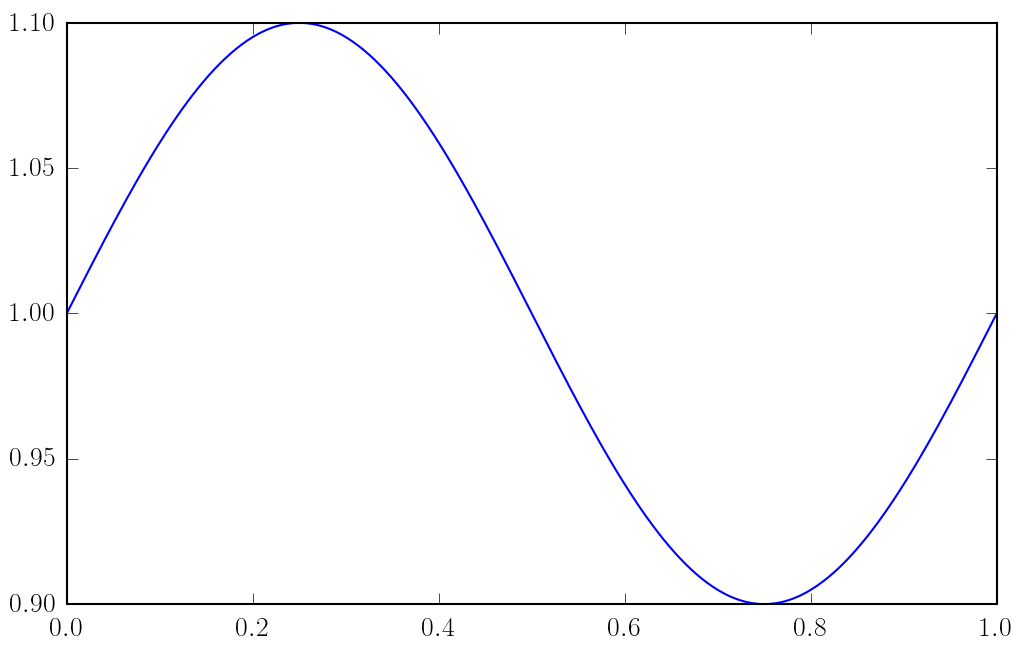

In [31]:
pl.plot(x, rhoInit(x))

In [32]:
gridPoint = N/4
solnVst = np.zeros(Nt)
for n in range(Nt):
    #print ("n = ", n)
    integral = quad(rhoIntegrand, -np.inf, np.inf, args=(x[gridPoint], t[n]))
    solnVst[n]  = integral[0]

n =  0
n =  1
n =  2
n =  3
n =  4
n =  5
n =  6
n =  7


/home/hyperion/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


n =  8
n =  9
n =  10
n =  11
n =  12
n =  13
n =  14
n =  15
n =  16
n =  17
n =  18
n =  19
n =  20
n =  21
n =  22
n =  23
n =  24
n =  25
n =  26
n =  27
n =  28
n =  29
n =  30
n =  31
n =  32
n =  33
n =  34
n =  35
n =  36
n =  37
n =  38
n =  39
n =  40
n =  41
n =  42
n =  43
n =  44
n =  45
n =  46
n =  47
n =  48
n =  49
n =  50
n =  51
n =  52
n =  53
n =  54
n =  55
n =  56
n =  57
n =  58
n =  59
n =  60
n =  61
n =  62
n =  63
n =  64
n =  65
n =  66
n =  67
n =  68
n =  69
n =  70
n =  71
n =  72
n =  73
n =  74
n =  75
n =  76
n =  77
n =  78
n =  79
n =  80
n =  81
n =  82
n =  83
n =  84
n =  85
n =  86
n =  87
n =  88
n =  89
n =  90
n =  91
n =  92
n =  93
n =  94
n =  95
n =  96
n =  97
n =  98
n =  99
n =  100
n =  101
n =  102
n =  103
n =  104
n =  105
n =  106
n =  107
n =  108
n =  109
n =  110
n =  111
n =  112
n =  113
n =  114
n =  115
n =  116
n =  117
n =  118
n =  119
n =  120
n =  121
n =  122
n =  123
n =  124
n =  125
n =  126
n =  127
n =  128
n =  

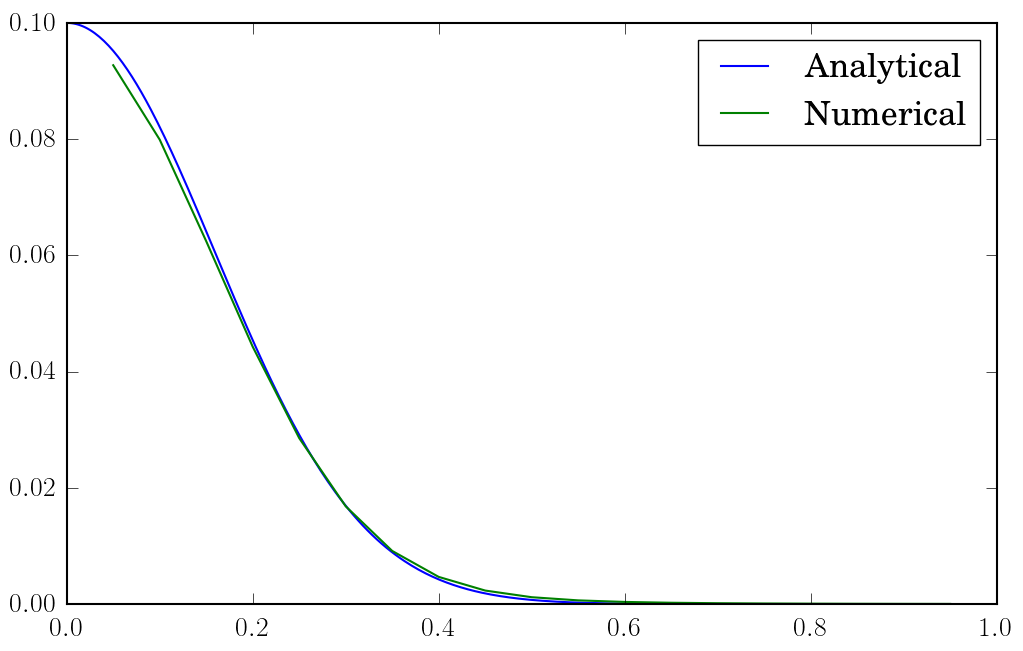

In [33]:
pl.plot(t, np.abs(solnVst - rho0), label='Analytical')
pl.plot(time, np.abs(rho_max - 1), label='Numerical')
pl.legend()